<a href="https://colab.research.google.com/github/dusarp/omdena-frankfurt-urban-green-space-mapping/blob/main/Copy_of_GeospatialDataExercises_Dorothea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Data Exercises

Question: were you using ChatGPT or an equivalent model?

Before we start: did you come across the concept of vector data and raster data? If so, did you find out what each one is:
Vector data and raster data are two primary formats used in Geographic Information Systems (GIS) to represent spatial information. Vector data uses points, lines, and polygons to represent discrete features like roads, buildings, and administrative boundaries, providing high precision and compact storage. It is ideal for applications requiring accurate representations and operations such as buffering and spatial joins. In contrast, raster data represents the world as a grid of cells or pixels, with each cell containing a value that corresponds to a property such as elevation, temperature, or land cover. In other words, a numpy array can represent raster data. Raster data is best suited for continuous data analysis, such as remote sensing and terrain modeling, but its resolution depends on cell size, often requiring large storage for high-quality data. While vector data excels in representing sharp boundaries and locations, raster data is more appropriate for modeling gradients and continuous phenomena. Each format has distinct strengths, and the choice between them depends on the nature of the data and the analysis requirements.

## (1) Getting started with google earth engine

Repeat this tutorial (https://www.youtube.com/watch?v=E65mfjqIwZI) for the German States.



In [ ]:
### Install necessary libraries

! pip install earthengine-api
! pip install geemap
! pip install --upgrade geopandas
! pip install --upgrade pyshp
! pip install --upgrade shapely
! pip install --upgrade descartes
! pip install rasterio
! pip install fiona
! pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.8 MB/s eta 0:00:00


In [ ]:
### import necessary libraries

import ee
import geemap
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fiona
from google.colab import drive

In [ ]:
### start google earth engine

your_authentication_gee_project = "dp-ee-omdena" # add your project name here

ee.Authenticate()
ee.Initialize(project=your_authentication_gee_project)

In [ ]:
### optional: start google drive to save files there

drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now you need to get information about the state boundaries of Germany. You can get that directly from GEE data catalogue:
https://developers.google.com/earth-engine/datasets

Search for German states and select "Datasets tagged borders in Earth Engine" -> here select "FAO GAUL: Global Administrative Unit Layers 2015, First-Level Administrative Units" and see that it is called ee.FeatureCollection("FAO/GAUL/2015/level1")

In [ ]:
### optional how to download a feature collection from earth engine and then filter it for Germany only

# Load the feature collection
feature_collection = ee.FeatureCollection('FAO/GAUL/2015/level1')

# Filter the collection for German states
german_states = feature_collection.filter(ee.Filter.eq('ADM0_NAME', 'Germany'))

# Print the filtered collection to check its properties
print(german_states.getInfo())

# Optionally export the filtered collection to Google Drive as GeoJSON
task = ee.batch.Export.table.toDrive(
    collection=german_states,
    description='German_States',
    fileFormat='GeoJSON'
)
task.start()

print("Export started. Check Google Drive for results.")

{'type': 'FeatureCollection', 'columns': {'ADM0_CODE': 'Integer', 'ADM0_NAME': 'String', 'ADM1_CODE': 'Integer', 'ADM1_NAME': 'String', 'DISP_AREA': 'String', 'EXP1_YEAR': 'Integer', 'STATUS': 'String', 'STR1_YEAR': 'Integer', 'Shape_Area': 'Float', 'Shape_Leng': 'Float', 'system:index': 'String'}, 'version': 1701682593235039, 'id': 'FAO/GAUL/2015/level1', 'properties': {'system:asset_size': 187606160}, 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[8.668149095345665, 47.689510517440034], [8.670177975417635, 47.688199567455754], [8.678926751619073, 47.69089728496002], [8.696179021933252, 47.696221525048], [8.70322885285809, 47.69590487783988], [8.703291228514203, 47.69590042760663], [8.712539437944372, 47.69288161048897], [8.719393096065238, 47.693349827675966], [8.721279269484322, 47.69347914408779], [8.720944902942469, 47.695169159575016], [8.720918076430927, 47.695298490162166], [8.720182346742016, 47.6962883561993], [8.713801349223912, 47.7

In [ ]:
import folium

# Load the feature collection
feature_collection = ee.FeatureCollection('FAO/GAUL/2015/level1')

# Filter the collection for German states
german_states = feature_collection.filter(ee.Filter.eq('ADM0_NAME', 'Germany'))

# Convert the filtered feature collection to GeoJSON
german_states_geojson = german_states.getInfo()  # Convert to a client-side dictionary
german_states_geojson = german_states_geojson['features']  # Extract features

# Convert features to GeoJSON format for folium
geojson = {
    "type": "FeatureCollection",
    "features": german_states_geojson
}

# Coordinates for Germany (center of the country)
germany_coordinates = [51.1657, 10.4515]  # Latitude and Longitude

# Create a folium map object
my_map = folium.Map(location=germany_coordinates, zoom_start=6)

# Add the German states layer to the folium map
folium.GeoJson(
    geojson,
    name="German States",
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.5
    }
).add_to(my_map)

# Add a layer control panel to the map
folium.LayerControl().add_to(my_map)

# Display the map
my_map.save("german_states_map.html")
my_map


<>

<>

## (2) Locating Frankfurt in Google Earth Engine and downloading a representative image of it

You can visualize Frankfurt am Main entirely using Google Earth Engine. To obtain accurate boundaries for Frankfurt am Main, you can utilize GeoJSON files from reliable sources. One such source is the Frankfurt Main Offene Geodaten repository on GitHub, which provides GeoJSON files for Frankfurt's city districts.

In [ ]:
import geemap
import geopandas as gpd

# Load the GeoJSON file containing Frankfurt's boundaries
geojson_url = 'https://raw.githubusercontent.com/GeoSchnitz/Frankfurt_Main-Offene_Geodaten/master/Stadtteil_Grenzen/ffm_city_districts_cartoDB.geojson'
gdf = gpd.read_file(geojson_url)

# Check the contents of the GeoDataFrame
print(gdf.head())

# Initialize the map centered around Frankfurt
Map = geemap.Map(center=[50.1109, 8.6821], zoom=12)

# Add the GeoDataFrame layer to the map
Map.add_gdf(gdf, layer_name='Frankfurt am Main Boundaries')

# Display the map
Map


              name  cartodb_id                created_at  \
0         Altstadt           1 2015-02-27 08:56:16+00:00   
1  Bahnhofsviertel           3 2015-02-27 08:56:16+00:00   
2        Niederrad          17 2015-02-27 08:56:16+00:00   
3           Hausen          21 2015-02-27 08:56:16+00:00   
4       Riederwald          33 2015-02-27 08:56:16+00:00   

                 updated_at                                           geometry  
0 2015-02-22 00:00:00+00:00  MULTIPOLYGON (((8.67744 50.10667, 8.67682 50.1...  
1 2015-02-22 00:00:00+00:00  MULTIPOLYGON (((8.662 50.10882, 8.66197 50.108...  
2 2015-02-22 00:00:00+00:00  MULTIPOLYGON (((8.6606 50.08916, 8.65969 50.08...  
3 2015-02-22 00:00:00+00:00  MULTIPOLYGON (((8.61758 50.14038, 8.61794 50.1...  
4 2015-02-22 00:00:00+00:00  MULTIPOLYGON (((8.72569 50.12305, 8.72527 50.1...  


Map(center=[50.1109, 8.6821], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

Next, we want to download a representative image of Frankfurt. Which raises the question: what is a representative image? Let's assume for a moment, that for us a representative image of Frankfurt is the entire Frankfurt. However, as you remember, the resolution of Sentinel-2 is 10m*10m per pixel for the RGB-channels. So getting an image with the highest potential resolution may be a bit too big for a download (at least what you are allowed to download by google earth).

In [ ]:
import ee
import geemap
import geopandas as gpd

# Load GeoJSON file containing Frankfurt's boundary
geojson_url = 'https://raw.githubusercontent.com/GeoSchnitz/Frankfurt_Main-Offene_Geodaten/master/Stadtteil_Grenzen/ffm_city_districts_cartoDB.geojson'
gdf = gpd.read_file(geojson_url)

# Combine all geometries into one (if necessary) -> this is a important function in geopandas that may come in handy later
gdf_combined = gdf.unary_union

# Convert the combined geometry to a GeoJSON dictionary
geojson_dict = gdf_combined.__geo_interface__

# Convert GeoJSON dictionary to an Earth Engine Geometry
frankfurt_boundary = ee.Geometry(geojson_dict)

# Define Sentinel-2 Image Collection and filter for Frankfurt region
image = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(frankfurt_boundary) \
    .filterDate('2022-01-01', '2022-12-31') \
    .sort('CLOUD_COVER') \
    .first()  # Select the least cloudy image

# Clip the image to Frankfurt's boundary
frankfurt_image = image.clip(frankfurt_boundary)

# Set visualization parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # True color: Red, Green, Blue
    'min': 0,
    'max': 3000
}

# Display the image using geemap
Map = geemap.Map(center=[50.1109, 8.6821], zoom=12)
Map.addLayer(frankfurt_image, vis_params, "Frankfurt Image")
Map.addLayerControl()
Map


Map(center=[50.1109, 8.6821], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

Instead of using the exact boundaries of Frankfurt, let's create an image where a regular box is drawn aroun the city:

In [ ]:
import ee
import geemap
import geopandas as gpd

# Load GeoJSON file containing Frankfurt's boundary
geojson_url = 'https://raw.githubusercontent.com/GeoSchnitz/Frankfurt_Main-Offene_Geodaten/master/Stadtteil_Grenzen/ffm_city_districts_cartoDB.geojson'
gdf = gpd.read_file(geojson_url)

# Calculate the bounding box of Frankfurt
bounding_box = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

# Convert the bounding box to an Earth Engine rectangle
frankfurt_bbox = ee.Geometry.Rectangle([bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3]])

# Define Sentinel-2 Image Collection and filter for the bounding box
image = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(frankfurt_bbox) \
    .filterDate('2022-01-01', '2022-12-31') \
    .sort('CLOUD_COVER') \
    .first()  # Select the least cloudy image

# Clip the image to the bounding box
frankfurt_image = image.clip(frankfurt_bbox)

# Set visualization parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # True color: Red, Green, Blue
    'min': 0,
    'max': 3000
}

# Display the image using geemap
Map = geemap.Map(center=[50.1109, 8.6821], zoom=12)
Map.addLayer(frankfurt_image, vis_params, "Frankfurt Image (Bounding Box)")
Map.addLayer(frankfurt_bbox, {'color': 'red'}, "Bounding Box")
Map.addLayerControl()
Map


/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Map(center=[50.1109, 8.6821], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [ ]:
import geemap

# Filter the Sentinel-2 image collection for low cloud cover
frankfurt_image = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(frankfurt_bbox)  # Filter by the bounding box
    .filterDate('2022-06-01', '2022-08-31')  # Filter by date
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter for low cloud cover
    .sort('CLOUD_COVER')  # Sort by cloud cover
    .first()  # Select the least cloudy image
)

# Define the output file path and name
output_file = "/content/drive/My Drive/frankfurt_image_2.tif"

# Export the image using geemap
try:
    geemap.ee_export_image(
        frankfurt_image.select(['B2', 'B3', 'B4']), #only download the RGB bands
        filename=output_file,
        scale=100,  # Set resolution in meters (adjust as needed)
        region=frankfurt_bbox.coordinates().getInfo(),  # Define the export region
        file_per_band=False  # Export as a single multiband file
    )
    print(f"Image successfully exported to {output_file}")
except Exception as e:
    print(f"An error occurred during export: {e}")


Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/frankfurt_image_2.tif
Image successfully exported to /content/drive/My Drive/frankfurt_image_2.tif


You may be surprised when your download was correct that when using paint or a similar visualization software you just see nothing. This is as to view GEOtiffs you need specialized software such as QGIS, ARCGIS, SNAP but also Fiji/ImageJ (https://fiji.sc/) can be used. OR, you use tif viewer to view the image online through your google drive

Alternatively, you may want to download an image of Frankfurt that uses the high resolution of Sentinel-2, i.e. where 1 pixel corresponds to an area of 10m*10m. In that case, you need to pick a constraint area in Frankfurt to not hit the size limit of what you are allowed to download from Google Earth Engine.

We can do so for example, to divide Frankfurt first into regular squares that are below the size limit for Google Earth Engine - let's pick a size typical for traditional supervised segmentation tasks: 256*256 pixels. In our case, that would be 2560 m * 2560 m per image:

In [ ]:
import math
import random

# Function to divide a bounding box into equally sized squares
def divide_bbox_into_squares(bbox, square_size):
    """
    Divide a bounding box into smaller squares of a given size.

    Args:
    bbox (list): Bounding box in [min_lon, min_lat, max_lon, max_lat].
    square_size (float): Size of the square in meters.

    Returns:
    list: A list of EE.Geometry.Rectangle representing the squares.
    """
    deg_per_meter_lat = 1 / 111000
    deg_per_meter_lon = 1 / (111000 * math.cos(math.radians((bbox[1] + bbox[3]) / 2)))

    square_size_lat = square_size * deg_per_meter_lat
    square_size_lon = square_size * deg_per_meter_lon

    min_lon, min_lat, max_lon, max_lat = bbox
    lon_range = max_lon - min_lon
    lat_range = max_lat - min_lat

    num_lon = math.ceil(lon_range / square_size_lon)
    num_lat = math.ceil(lat_range / square_size_lat)

    squares = []
    for i in range(num_lon):
        for j in range(num_lat):
            square_min_lon = min_lon + i * square_size_lon
            square_max_lon = min_lon + (i + 1) * square_size_lon
            square_min_lat = min_lat + j * square_size_lat
            square_max_lat = min_lat + (j + 1) * square_size_lat

            square_max_lon = min(square_max_lon, max_lon)
            square_max_lat = min(square_max_lat, max_lat)

            squares.append(
                ee.Geometry.Rectangle([square_min_lon, square_min_lat, square_max_lon, square_max_lat])
            )

    return squares

# Frankfurt bounding box coordinates
bounding_box = frankfurt_bbox.bounds().coordinates().getInfo()[0]
min_lon = min([coord[0] for coord in bounding_box])
max_lon = max([coord[0] for coord in bounding_box])
min_lat = min([coord[1] for coord in bounding_box])
max_lat = max([coord[1] for coord in bounding_box])

# Define square size in meters
square_size_m = 2560

# Generate squares
squares = divide_bbox_into_squares([min_lon, min_lat, max_lon, max_lat], square_size_m)

# Select a random square
random_square = random.choice(squares)

# Filter for cloud-free Sentinel-2 image
selected_image = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(random_square)
    .filterDate('2022-01-01', '2022-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .sort('CLOUD_COVER')
    .median()
)

# Center the map on the random square geometry
square_center = random_square.centroid().coordinates().getInfo()  # Get the center of the random square

Map2B = geemap.Map(center=square_center[::-1], zoom=14)  # Reverse to [lat, lon] for centering
Map2B.addLayer(selected_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Selected Image')
Map2B.addLayer(random_square, {'color': 'red'}, 'Random Square')
Map2B.addLayerControl()
Map2B

Map(center=[50.04984406054767, 8.706569591067895], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Export the image for the selected square
output_file = "/content/drive/My Drive/random_square_image.tif"

try:
    geemap.ee_export_image(
        selected_image.select(['B2', 'B3', 'B4']),  # RGB bands
        filename=output_file,
        scale=10,  # High resolution: 10m per pixel
        region=random_square.coordinates().getInfo(),  # Export region
        file_per_band=False  # Single multiband file
    )
    print(f"Image successfully exported to {output_file}")
except Exception as e:
    print(f"An error occurred during export: {e}")

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/random_square_image.tif
Image successfully exported to /content/drive/My Drive/random_square_image.tif


<>

<>

## (3) Next, we want to calculate spectral indixes in that image EVI, NEVI, MNDWI, RVI, NDVI, ARVI (have you already found the mock indices?).

So, let's step one step back and discuss what a spectral index is and why it is usefull.

Spectral indices are mathematical combinations of specific bands from multispectral or hyperspectral satellite imagery. These indices are designed to enhance particular features or phenomena, such as vegetation health, soil properties, water presence, or built-up areas, by exploiting the unique reflectance characteristics of surfaces in different parts of the electromagnetic spectrum.

Spectral indices are typically calculated using band ratios, differences, sums, or other operations. They are derived from reflectance values measured in specific spectral bands (e.g., red, near-infrared (NIR), blue) that are sensitive to the property of interest.

So, let's go over the proposed indices again to see when they were proposed and why and what is their formula - I listed:
- Enhanced Vegetation Index (EVI)
- Normalized Enhanced Vegetation Index (NEVI)
- Modified Normalized Difference Water Index (MNDWI)
- Ratio Vegetation Index (RVI)
- Normalized Difference Vegetation Index (NDVI)
- Atmospherically Resistant Vegetation Index (ARVI)


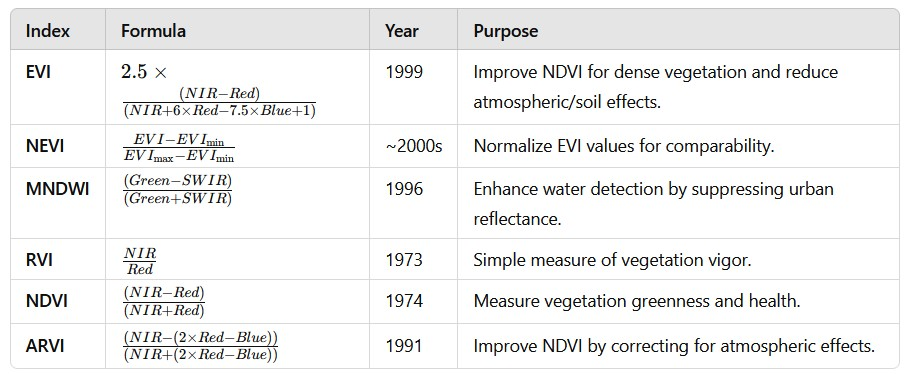

As you saw from the formulas spectral indices are based on relating the values of different spectral bands with each other. In an image, each pixel varies in its values across spectral bands. So, what we do is to calculate spectral indices for each pixel; thus, we get a new image with only one value per pixel: the spectral index of that pixel. This is useful for area detection and monitoring in satellite images. We can calculate spectral index images and visualize them directly in google earth engine (without having to download the image). Since, we are using satellite images already corrected for many atmospheric effects, let's initially just compare how an image looks when calculating NDVI, RVI, and MNDWI.

In [ ]:
##### the calculation of NDVI in ee is pretty straight forward:

# Calculate NDVI
# Formula: (NIR - Red) / (NIR + Red)
ndvi = selected_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Visualization parameters for NDVI
ndvi_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']  # Colors: low NDVI to high NDVI
}

# Display the NDVI image on a map
Map3A = geemap.Map()
Map3A.centerObject(selected_image, 12)  # Adjust the zoom level as needed
Map3A.addLayer(ndvi, ndvi_vis_params, 'NDVI')
Map3A.addLayerControl()
Map3A

Map(center=[50.05688824403754, 8.369284912940781], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Calculate MNDWI
# Formula: (Green - SWIR) / (Green + SWIR)
mndwi = selected_image.normalizedDifference(['B3', 'B11']).rename('MNDWI')

# Visualization parameters for MNDWI
mndwi_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['brown', 'white', 'blue']  # Colors: low MNDWI to high MNDWI
}

# Display the MNDWI image on a map
Map3B = geemap.Map()
Map3B.centerObject(selected_image, 12)  # Adjust the zoom level as needed
Map3B.addLayer(mndwi, mndwi_vis_params, 'MNDWI')
Map3B.addLayerControl()
Map3B

Map(center=[50.05688824403754, 8.369284912940781], controls=(WidgetControl(options=['position', 'transparent_b…

Note the difference in the structures that are mapped out and that are not so enhanced?

Some more literature about spectral indices:

◦	https://www.sciencedirect.com/science/article/pii/S1470160X24011026
◦	https://journals.vilniustech.lt/index.php/GAC/article/download/18724/12263
◦	https://d1wqtxts1xzle7.cloudfront.net/84839310/j.rse.2012.10.02920220425-1-1ibpxp0-libre.pdf?1650876954=&response-content-disposition=inline%3B+filename%3DQuantifying_tree_mortality_in_a_mixed_sp.pdf&Expires=1729243529&Signature=RKZZAnCubdlNggjklkofw4~EztKwSyoWCiYtaeMO~OHnz8iwP-quks3~ZDXYR50UJUp9507EMezA8p20R2GhcZemKNKA4K27m4AjPsMEcRMGf34r-uC2uuDIHEzah5tu-T3Do3SHeAmteNxjn8dQ0JekBNnAquSQx2ASk9d3NXcTRteWWCDoBsgHpjksf5~0~YTE5RB~-jIQeG33hr6-IVQWBdpuQG5~~rWnOaUG~Qz9d3tsdLe8ky8pC7ZcDXFyKW-J0hdC08HRIKr1A535R6BOEKEdvx~VXqNC63eUVY8TsflEFyTOJBpFg3GB8yI3gWTK3oxApTEwSeBTnTjL5w__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA


<>

<>

## (4) Download an average image (e.g. from 2023) for the months January and February and calculate the indices again – repeat for the months May and June

So, this exercise has two parts: (A) understand and implement the download of a satellite image from a specific time range - here we are interested in an average of spectral intensities for a given time range; (B) calculate spectral indices again - but this time outside of the earth engine library - which is actually very easy.

In [ ]:
### instead of an average, we will create a median image this time

summer_selected_image = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(random_square)
    .filterDate('2022-05-01', '2022-08-31') # here you can set the dates to only pick summer images
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .sort('CLOUD_COVER')
    .median() # this changes to create a median image
)

# Export the summer image for the selected square
output_file = "/content/drive/My Drive/summer_square_image.tif"

try:
    geemap.ee_export_image(
        selected_image.select(['B2', 'B3', 'B4', 'B5']),  # RGB bands plus NIR
        filename=output_file,
        scale=10,  # High resolution: 10m*10m per pixel
        region=random_square.coordinates().getInfo(),  # Export region
        file_per_band=False  # Single multiband file
    )
    print(f"Image successfully exported to {output_file}")
except Exception as e:
    print(f"An error occurred during export: {e}")

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/summer_square_image.tif
Image successfully exported to /content/drive/My Drive/summer_square_image.tif


In [ ]:
### now the winter

winter_selected_image = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(random_square)
    .filterDate('2021-12-01', '2022-02-31') # here you can set the dates to only pick winter images
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .sort('CLOUD_COVER')
    .median() # this changes to create a median image
)

# Export the summer image for the selected square
output_file = "/content/drive/My Drive/winter_square_image.tif"

try:
    geemap.ee_export_image(
        selected_image.select(['B2', 'B3', 'B4', 'B5']),  # RGB bands plus NIR
        filename=output_file,
        scale=10,  # High resolution: 10m*10m per pixel
        region=random_square.coordinates().getInfo(),  # Export region
        file_per_band=False  # Single multiband file
    )
    print(f"Image successfully exported to {output_file}")
except Exception as e:
    print(f"An error occurred during export: {e}")

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/winter_square_image.tif
Image successfully exported to /content/drive/My Drive/winter_square_image.tif


Now, let's re-upload the images into colab (I know - how

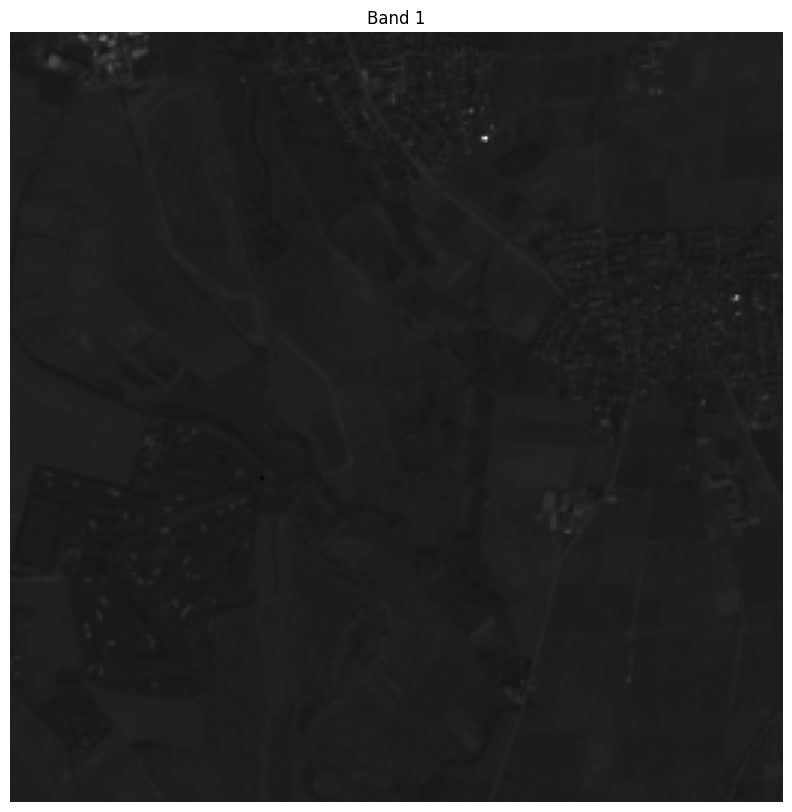

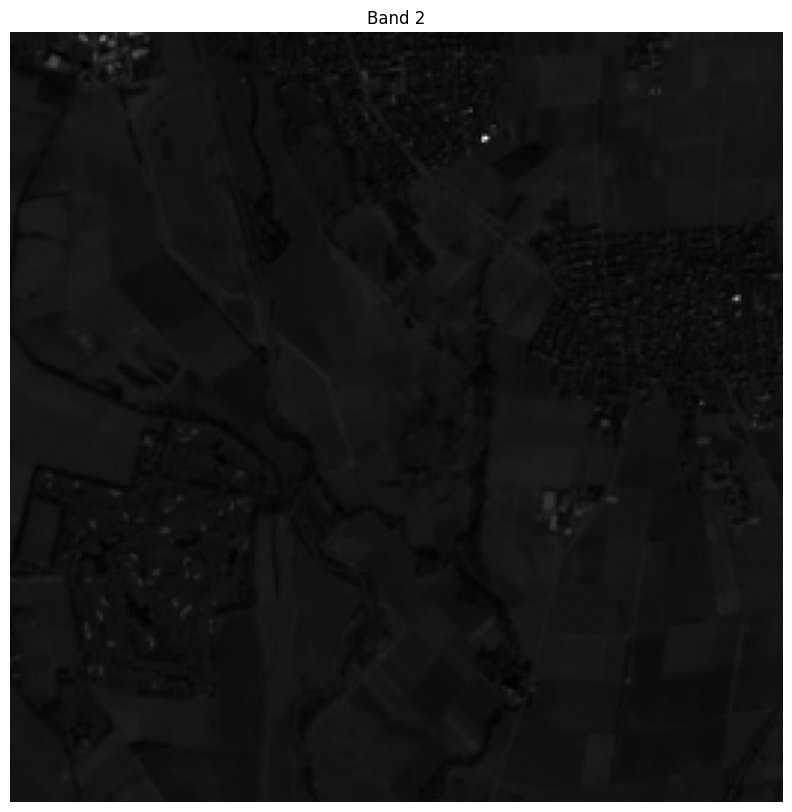

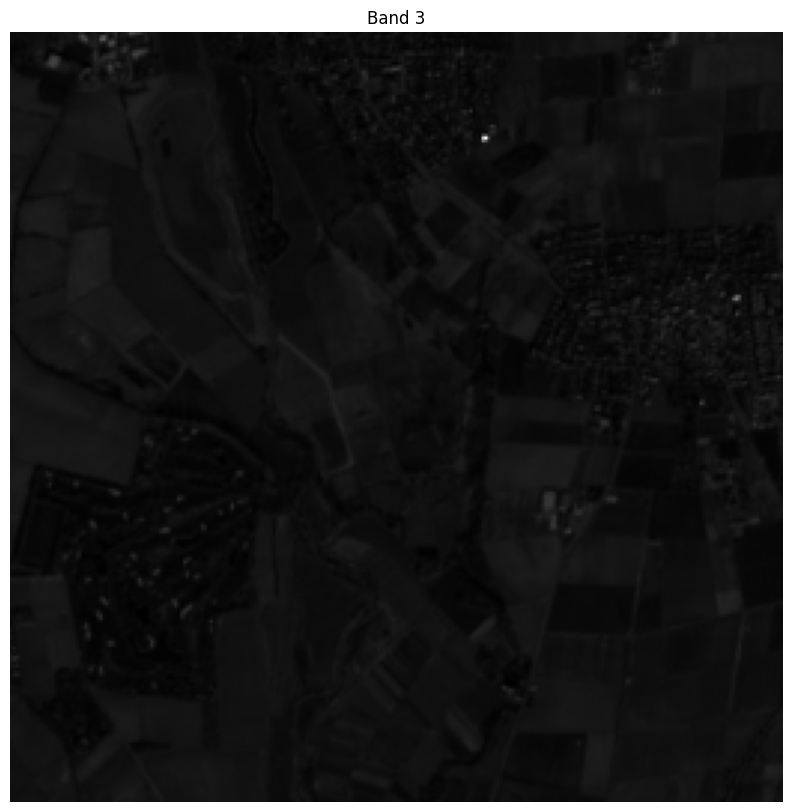

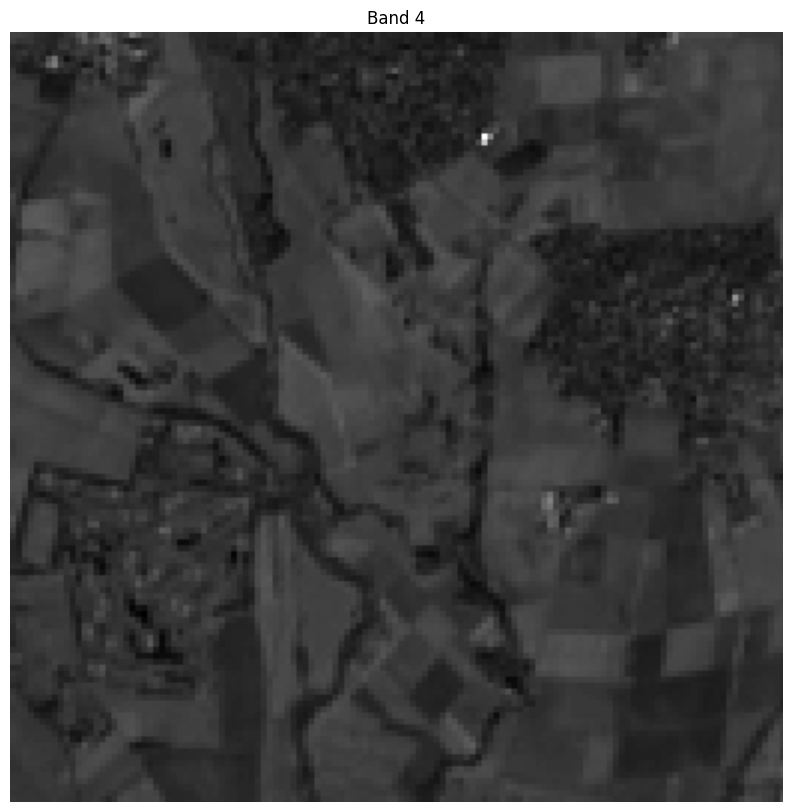

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Define the file path
file_path = "/content/drive/My Drive/winter_square_image.tif"

# Load and display all bands of the GeoTIFF
try:
    with rasterio.open(file_path) as src:
        # Get the total number of bands in the image
        num_bands = src.count

        # Iterate through all bands and display each one
        for band_idx in range(1, num_bands + 1):  # Bands are 1-indexed in Rasterio
            band = src.read(band_idx)

            # Display the band
            plt.figure(figsize=(10, 10))
            plt.imshow(band, cmap='gray')
            plt.title(f"Band {band_idx}")
            plt.axis('off')
            plt.show()

except Exception as e:
    print(f"An error occurred while reading the GeoTIFF: {e}")

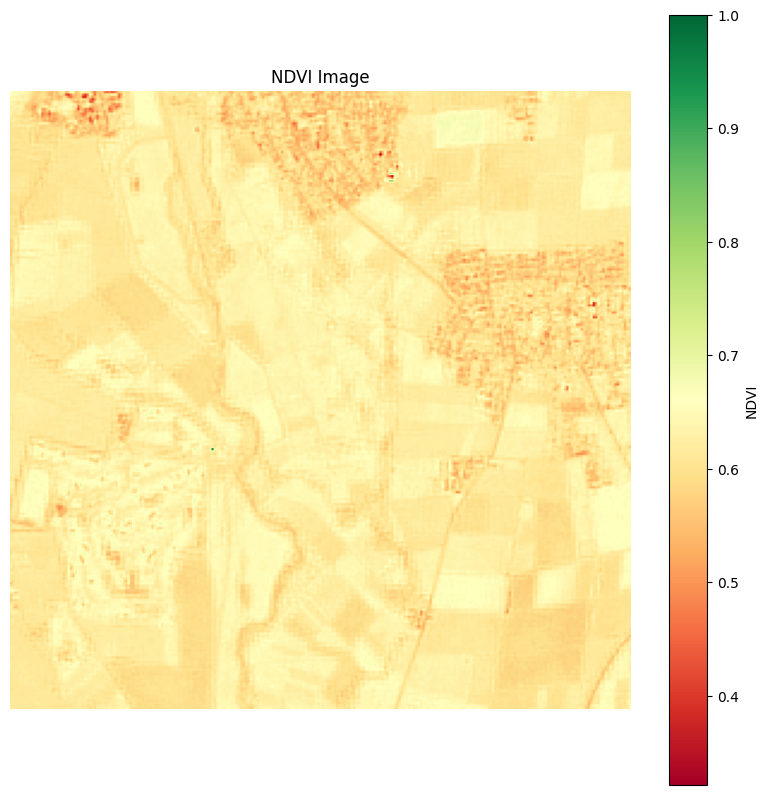

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the image and calculate NDVI
try:
    with rasterio.open(file_path) as src:
        # Read bands (assuming R, G, B, NIR are bands 1, 2, 3, 4 respectively)
        red = src.read(1).astype('float32')  # Band 1
        nir = src.read(4).astype('float32')  # Band 4 (NIR)

        # Avoid division by zero by adding a small constant
        epsilon = 1e-10
        ndvi = (nir - red) / (nir + red + epsilon)  # Calculate NDVI

        # Normalize NDVI for visualization (-1 to 1 range)
        ndvi_normalized = (ndvi + 1) / 2

        # Display NDVI
        plt.figure(figsize=(10, 10))
        plt.imshow(ndvi_normalized, cmap='RdYlGn')
        plt.colorbar(label='NDVI')
        plt.title("NDVI Image")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"An error occurred while processing the GeoTIFF: {e}")

And then repeat for summer - which differences do you see?

<>

<>

## (5) Cluster the pixels of an image!

So far, we downloaded satellite images with a subset of potential spectral bands. Remember, each band gives value measurements for each pixel in the image. In other words, we have values for 13 variables. Thus, it seems feasible to map how similar pixels are among each other and potentially group them, i.e. through clustering. In a first attempt, we will let aside the vast world of clustering methodologies and pick one clustering strategy for the sake of picking one.

This is not to say that for pixel characterization clustering is outdated; quite in contrary, there are recent publications using this strategy. See for example here: https://d1wqtxts1xzle7.cloudfront.net/85202457/cict.2013.655809020220430-1-1hiu6g4-libre.pdf?1651289932=&response-content-disposition=inline%3B+filename%3DClassification_of_satellite_images_using.pdf&Expires=1733845034&Signature=MXY8mEfHJ7ZlRrKzxzJCrrA4v59Ei2nKO-I-RbIgH40fELhH5C9mA8Y2dCRUDDOwx0YBfwnFsVwKNlonN8-kgCRwRihzIim6h6MBigqW9Qcmft9byXMwKxF2oPi~KuX0XuIpOtH~iVisLfyiB9ioWVM9jX~EXCRGCfBR6xOV5sjWwYvieWHmxjRz9gU1n3P~M6QGaI4YsDJ0RMcwxy0pABAv8guuY10ZBxzXIdX96ynq9ngxFYOkdHk0t7osSiLeL95YC22PnMKLGdrxhx9liJyQWyf2IX9wWwyib48CP5RgkRcd0bXzrEkPL2XvOzBauEAqN7wJi97KxlDwhs62MQ__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA

This may be also interesting:

https://www.haw-hamburg.de/fileadmin/LS/FTZ-NK/PDF/Publications/Clustering_public_urban_green_spaces.pdf?utm_source=chatgpt.com

For now, we will cluster our downloaded satellite image outside of google earth engine using the librarx scikit. So, let's install it:

In [ ]:
! pip install -U scikit-learn
! pip install scikit-learn-intelex
! pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 MB 8.8 MB/s eta 0:00:00


In [ ]:
### First download an image with 13 bands

# We take the original random square image again but this time select all bands
output_file = "/content/drive/My Drive/random_square_image_allbands.tif"

try:
    geemap.ee_export_image(
        selected_image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']),
        filename=output_file,
        scale=10,  # High resolution: 10m per pixel
        region=random_square.coordinates().getInfo(),  # Export region
        file_per_band=False  # Single multiband file
    )
    print(f"Image successfully exported to {output_file}")
except Exception as e:
    print(f"An error occurred during export: {e}")

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/random_square_image_allbands.tif
Image successfully exported to /content/drive/My Drive/random_square_image_allbands.tif


In [ ]:
### then we upload the image again

import rasterio
import numpy as np

# Define the file path
file_path = "/content/drive/My Drive/random_square_image_allbands.tif"

# Load and display all bands of the GeoTIFF
try:
    with rasterio.open(file_path) as src:
        # Get the total number of bands in the image
        num_bands = src.count
        bands_data = []

        # Iterate through all bands and add to bands_data
        for band_idx in range(1, num_bands + 1):  # Bands are 1-indexed in Rasterio
            band = src.read(band_idx)
            bands_data.append(band)

        # Stack bands into one numpy array
        stacked_data = np.stack(bands_data, axis=-1)  # Shape: (rows, cols, bands)

        print(f"GeoTIFF loaded successfully with shape: {stacked_data.shape}")
        print(f"Number of bands: {num_bands}")

except Exception as e:
    print(f"An error occurred while reading the GeoTIFF: {e}")


GeoTIFF loaded successfully with shape: (258, 259, 12)
Number of bands: 12


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


DBSCAN clustering completed. Number of clusters: 144
Noise points: 10948


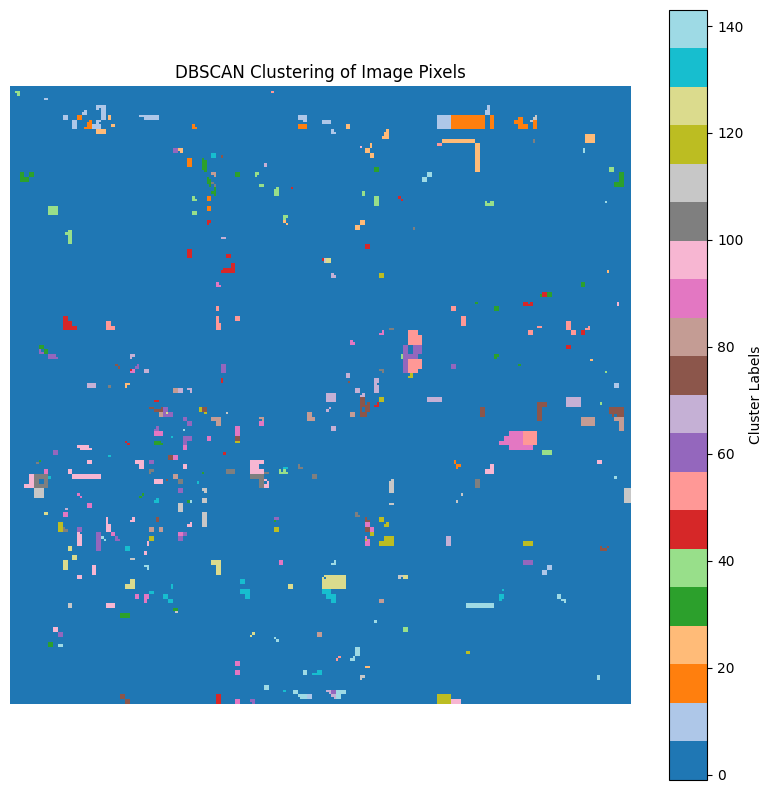

In [ ]:
### and now do the clustering (let's chose dbscan for now) using the intelx patch for faster performance

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import DBSCAN

# Reshape the image data to (num_pixels, num_bands) for clustering
rows, cols, bands = stacked_data.shape
flat_data = stacked_data.reshape((-1, bands))

# Apply DBSCAN Clustering
try:
    # Normalize the data
    flat_data_normalized = (flat_data - flat_data.min(axis=0)) / (flat_data.ptp(axis=0) + 1e-10)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.05, min_samples=10, metric='euclidean')  # Adjust parameters as needed
    cluster_labels = dbscan.fit_predict(flat_data_normalized)

    print(f"DBSCAN clustering completed. Number of clusters: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
    print(f"Noise points: {np.sum(cluster_labels == -1)}")

    # Step 3: Reshape the cluster labels to the original image dimensions
    clustered_image = cluster_labels.reshape((rows, cols))

    # Step 4: Visualize the clustering result
    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap='tab20', interpolation='none')
    plt.colorbar(label="Cluster Labels")
    plt.title("DBSCAN Clustering of Image Pixels")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"An error occurred during clustering: {e}")

Well, that result is not soooo useful but let's go on to see why we bother.

<>

<>

## (6) Cluster the pixels of an image derived from spectral indices – do this inside and outside of GEE

Why are we doing it: to get a feeling for the power of spectral indices. And, to dive a bit deeper into the earth engine world - this suit offers very paticular methodologies in image analysis. And, as reminder to use as much as possibly programming helpers such as ChatGPT because there is so much specific knowledge required for libraries such as earth engine.

So, let's repeat our clustering outside of GEE using spectral indices. Here, randomely focus on the spectral indices: NDBI, NDVI, MNDWI, and RVI.

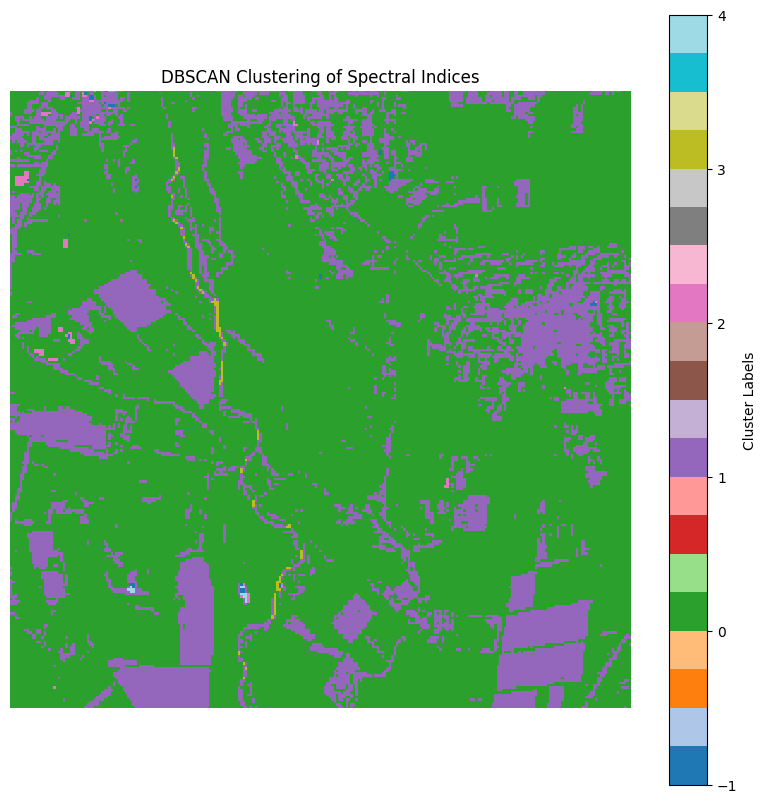

In [ ]:
# Band indices for Sentinel-2 data
B3 = stacked_data[:, :, 2]  # Green
B4 = stacked_data[:, :, 3]  # Red
B8 = stacked_data[:, :, 7]  # NIR
B11 = stacked_data[:, :, 10]  # SWIR1

# Avoid division by zero
epsilon = 1e-10

# Calculate spectral indices
ndbi = (B11 - B8) / (B11 + B8 + epsilon)  # NDBI
ndvi = (B8 - B4) / (B8 + B4 + epsilon)   # NDVI
mndwi = (B3 - B11) / (B3 + B11 + epsilon)  # MNDWI
rvi = B8 / (B4 + epsilon)  # RVI

# Stack indices into a new numpy array
indices_stack = np.stack([ndbi, ndvi, mndwi, rvi], axis=-1)  # Shape: (rows, cols, 4)

# Reshape for clustering: (num_pixels, num_features)
rows, cols, features = indices_stack.shape
flat_indices = indices_stack.reshape((-1, features))

# Normalize the indices for clustering
flat_indices_normalized = (flat_indices - flat_indices.min(axis=0)) / (flat_indices.ptp(axis=0) + epsilon)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.05, min_samples=10, metric='euclidean')  # Adjust parameters as needed
cluster_labels = dbscan.fit_predict(flat_indices_normalized)

# Reshape the clustering result back to image dimensions
clustered_image = cluster_labels.reshape((rows, cols))

# Display the clustered result
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image, cmap='tab20', interpolation='none')
plt.colorbar(label="Cluster Labels")
plt.title("DBSCAN Clustering of Spectral Indices")
plt.axis('off')
plt.show()

Looks a lot different - right! And, it seems like a lot more structures are recognizable now.

And, let's do that inside of GEE:

In [ ]:
bands_to_cluster = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
clustering_image = selected_image.select(bands_to_cluster)

# Make the training dataset.
training = clustering_image.sample(region=selected_image.geometry(), scale=10, numPixels=5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(5).train(training)

# Cluster the input using the trained clusterer.
result = clustering_image.cluster(clusterer)

# Step 5: Display the clustered image
Map6B = geemap.Map()
Map6B.centerObject(selected_image, 10)  # Center the map on the image
Map6B.addLayer(result.randomVisualizer(), {}, 'clusters')
Map6B.addLayerControl()
Map6B

Map(center=[50.05688824403754, 8.369284912940781], controls=(WidgetControl(options=['position', 'transparent_b…

Beautifull isn't it? The ee library comes with a small number of pre-chosen algorithmic approaches for e.g. clustering - i.e. methods that have been extensively researched to work. It has for example only the following clustering options to chose from: wekaKMeans, wekaCascadeKMeans, wekaCobweb, wekaLVQ and wekaXMeans.

<>

<>

## (7) Use GEE to calculate the Water Balance using Precipitation and Evapotranspiration for 2023

A tutorial how to do it can be found for example here: https://www.youtube.com/watch?v=CRV0Q3naHdc

Water Balance=Precipitation−Evapotranspiration

The script assumes you have access to a precipitation dataset (e.g., CHIRPS) and an evapotranspiration dataset (e.g., MODIS Global Evapotranspiration).

In code that looks like:

In [ ]:
# Define the region of interest (Frankfurt am Main)
frankfurt = ee.Geometry.Point([8.6821, 50.1109]).buffer(10000)  # A 10km buffer around Frankfurt

# Define the time range
start_date = '2022-01-01'
end_date = '2022-12-31'

# Load precipitation data (CHIRPS dataset)
precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(frankfurt) \
    .filterDate(start_date, end_date) \
    .select('precipitation') \
    .sum()  # Sum over the time range

# Load evapotranspiration data (MODIS Global Evapotranspiration)
evapotranspiration = ee.ImageCollection("MODIS/006/MOD16A2") \
    .filterBounds(frankfurt) \
    .filterDate(start_date, end_date) \
    .select('ET') \
    .sum() \
    .multiply(0.1)  # Scale factor for MODIS ET data

# Calculate the water balance
water_balance = precipitation.subtract(evapotranspiration)

# Visualization parameters
precip_vis_params = {'min': 0, 'max': 1000, 'palette': ['blue', 'cyan']}
et_vis_params = {'min': 0, 'max': 500, 'palette': ['orange', 'red']}
wb_vis_params = {'min': -500, 'max': 500, 'palette': ['brown', 'white', 'green']}

# Create a map
Map7 = geemap.Map()
Map7.centerObject(frankfurt, 10)

# Add layers to the map
Map7.addLayer(precipitation, precip_vis_params, 'Precipitation (mm)')
Map7.addLayer(evapotranspiration, et_vis_params, 'Evapotranspiration (mm)')
Map7.addLayer(water_balance, wb_vis_params, 'Water Balance (mm)')

# Display the map
Map7.addLayerControl()
Map7



Map(center=[50.11091025887285, 8.682100443614404], controls=(WidgetControl(options=['position', 'transparent_b…

code was generated using ChatGPT...

<>

<>

## (8) Segment streets using publically available street maps

This bonus question may be one of the most relevant exercises here: after all, we need to generate ground truth data and the strategy may be similar to that one proposed for this exercise. The idea is that to determine how good our final results are, we need to have something for comparison. There are two potential approaches: (1) generate our final truth and then set it aside - in the meantime use unsupervised learning, such as e.g. clustering for pixel-level classification or segmentation. (2) use our labelled data to help the computer learn the patterns (supervised learning). For the moment, to keep the protocols short and do not overload you with methodologoes, let's stick to clustering, i.e. unsupervised learning.

But first, get to the part where we generate our ground truth - remember the image we selected in earth engine ("selected_image")? Let's find that area in a reliable, open-source map repository like Open Street Map.

Open Street Map in a nutshell:
OpenStreetMap (OSM) is a collaborative project that provides freely accessible and editable geographic data and maps. It is often referred to as the "Wikipedia of maps" because anyone can contribute to its creation and refinement.
OSM relies on data contributions from volunteers and organizations worldwide.
OSM data is organized into three primary components:
        Nodes: Points with specific coordinates, used for features like POIs or as vertices for lines and polygons.
        Ways: Ordered lists of nodes representing linear features (e.g., roads) or boundaries (e.g., buildings).
        Relations: Groupings of nodes, ways, or other relations that represent complex structures (e.g., a bus route).
Each element has associated tags, which are key-value pairs describing the feature (e.g., highway=residential, building=school). OSM data itself is raw geographic information. To create visual maps, rendering Engines like Mapnik or OsmAnd interpret the data and apply cartographic styles. OSM data is available under the Open Database License (ODbL), allowing free use, modification, and distribution, provided contributors are credited. It is managed by the OpenStreetMap Foundation (OSMF), which oversees the project’s infrastructure and community. Local communities and user groups organize events like mapathons to improve coverage and quality.

In a first step, we create our ground truth. Let's say we are interested in knowing the area percentage made up of streets and paved pedastrian walks within the area covered by selected_image. To achieve this, you can use the Python osmnx library to query OpenStreetMap (OSM) data

In [ ]:
! pip install --upgrade osmnx

In [ ]:
import osmnx as ox
print(ox.__version__)


2.0.0


In [ ]:
### This may take long - consider using OSMPythonTools if it takes too long

import osmnx as ox
from shapely.geometry import box

# Step 1: Get the bounding box of the selected_image
def get_bounding_box(image):
    """Extracts the bounding box of an Earth Engine image."""
    bounds = image.geometry().bounds().getInfo()['coordinates']
    min_lon = bounds[0][0][0]
    min_lat = bounds[0][0][1]
    max_lon = bounds[0][2][0]
    max_lat = bounds[0][2][1]
    return min_lon, min_lat, max_lon, max_lat

# Extract bounding box of selected_image
min_lon, min_lat, max_lon, max_lat = get_bounding_box(selected_image)

# Create a bounding box polygon
bbox_polygon = box(min_lon, min_lat, max_lon, max_lat)

# Define tags to retrieve polygons for streets and pedestrian pathways
tags = {'highway': ['pedestrian', 'footway', 'path', 'cycleway']} # This retrieves all highway-related features
tags2 = {
    'highway': [
        'pedestrian', 'footway', 'path', 'cycleway',
        'motorway', 'primary', 'secondary', 'tertiary',
        'residential'
    ]
}

# Fetch the data from OSM
gdf = ox.features_from_polygon(bbox_polygon, tags)

# Filter to include only polygon geometries
gdf = gdf[gdf.geometry.type == 'Polygon']

# Project to a metric CRS for accurate area calculations
gdf = gdf.to_crs(epsg=3857)

# Calculate the area in square meters
gdf['area_sqm'] = gdf.geometry.area

# Display the total area
total_area = gdf['area_sqm'].sum()
print(f"Total area of streets and pedestrian pathways: {total_area:.2f} square meters")


Total area of streets and pedestrian pathways: 53187.46 square meters


Now, let's cluster our image and get the area of each cluster. This time, we use a fuzzy clustering algorithm - in short here every pixel is assigned percentages of how much it belongs to a specific cluster. Scikit-learn does not have a built-in implementation of fuzzy k-means clustering (also known as fuzzy c-means). However, you can use the skfuzzy library, which is part of the SciKit-Fuzzy package. This library provides an implementation of fuzzy c-means clustering.  
We will add up found percentages to calculate the total area of each predicted class in the image. Note, the caveat of this unsupervised approached is that there is no guarantee that a cluster "streets" is created - instead, a cluster encompassing both streets and buildings could be created. Thus, you may be interested in doing a supervised pixel-level classification - potentially one with fuzzy assignments to classes. To do so, you would need to create masks for each class: these are images consisting only of one matrix; the matrix has in the traditional case only one of two values 0 for this class is not present in this pixel or 1 for this class is present in the pixel. Creation of these masks can be for example done using the python library rasterio - for this, the vector data of open street map present in the selected area is converted into raster form (i.e. a matrix).

In [ ]:
# Assuming that you may need to re-download selected_image
output_file = "/content/drive/My Drive/fuzzy_cluster_image2.tif"

try:
    geemap.ee_export_image(
        selected_image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']),  # let's go for all as we do not know what we are looking for
        filename=output_file,
        scale=10,  # High resolution: 10m*10m per pixel
        region=random_square.coordinates().getInfo(),  # Export region
        file_per_band=False  # Single multiband file
    )
    print(f"Image successfully exported to {output_file}")
except Exception as e:
    print(f"An error occurred during export: {e}")

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/fuzzy_cluster_image2.tif
Image successfully exported to /content/drive/My Drive/fuzzy_cluster_image2.tif


In [ ]:
### then we upload the image again

import rasterio
import numpy as np

# Define the file path
file_path = "/content/drive/My Drive/fuzzy_cluster_image2.tif"

# Load and display all bands of the GeoTIFF
try:
    with rasterio.open(file_path) as src:
        # Get the total number of bands in the image
        num_bands = src.count
        bands_data = []

        # Iterate through all bands and add to bands_data
        for band_idx in range(1, num_bands + 1):  # Bands are 1-indexed in Rasterio
            band = src.read(band_idx)
            bands_data.append(band)

        # Stack bands into one numpy array
        stacked_data = np.stack(bands_data, axis=-1)  # Shape: (rows, cols, bands)

        print(f"GeoTIFF loaded successfully with shape: {stacked_data.shape}")
        print(f"Number of bands: {num_bands}")

except Exception as e:
    print(f"An error occurred while reading the GeoTIFF: {e}")

GeoTIFF loaded successfully with shape: (258, 402, 12)
Number of bands: 12


In [ ]:
! pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 22.2 MB/s eta 0:00:00


In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import skfuzzy as fuzz

# Assume stacked_data is a 3D NumPy array with shape (height, width, bands)
# Flatten the 3D image into 2D for clustering (each row is a pixel, each column is a band)
height, width, bands = stacked_data.shape
reshaped_data = stacked_data.reshape(-1, bands).T  # Transpose for FCM input format

# Number of clusters
n_clusters = 7

# Perform fuzzy c-means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    reshaped_data, n_clusters, 2, error=0.005, maxiter=1000, init=None
)

# Membership probabilities for each class (n_clusters x n_pixels)
pixel_membership = u.T

# Determine the class for each pixel based on maximum membership probability
pixel_classes = np.argmax(pixel_membership, axis=1)

# Count the number of pixels in each class
class_counts = np.zeros(n_clusters)
for i in range(n_clusters):
    class_counts[i] = np.sum(pixel_membership[:, i])

# Convert counts to percentages
total_pixels = reshaped_data.shape[1]
class_percentages = (class_counts / total_pixels) * 100

# Store percentages in a dictionary
class_percentages_dict = {f"Class_{i+1}": class_percentages[i] for i in range(n_clusters)}

print("Class Percentages:", class_percentages_dict)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Class Percentages: {'Class_1': 16.694738425767444, 'Class_2': 16.89797756128791, 'Class_3': 15.854462138953773, 'Class_4': 17.085145648320747, 'Class_5': 4.413325433542687, 'Class_6': 15.702426963663083, 'Class_7': 13.35192382846436}


In [ ]:
# Now predict the total area of each class in that image based on the fuzzy percentages

# Sum of all class percentages
sum_of_sums = sum(class_percentages_dict.values())

# Calculate the percentage contribution of each class to the total sum of sums
percentage_contributions = {
    class_name: (value / sum_of_sums) * 100 for class_name, value in class_percentages_dict.items()
}

# Area of one pixel in square meters
pixel_area = 256 * 256  # 65,536 m²

# Total number of pixels
total_pixels = height * width

# Total area covered by all pixels
total_area = total_pixels * pixel_area  # in square meters

# Predicted area for each class
predicted_areas = {
    class_name: (percentage / 100) * total_area for class_name, percentage in percentage_contributions.items()
}

print("Percentage Contributions:", percentage_contributions)
print("Predicted Areas (m²):", predicted_areas)

Percentage Contributions: {'Class_1': 16.69473842576744, 'Class_2': 16.89797756128791, 'Class_3': 15.854462138953771, 'Class_4': 17.085145648320747, 'Class_5': 4.413325433542686, 'Class_6': 15.702426963663079, 'Class_7': 13.351923828464358}
Predicted Areas (m²): {'Class_1': 1134763370.457921, 'Class_2': 1148577802.3196504, 'Class_3': 1077648683.960716, 'Class_4': 1161299863.8378906, 'Class_5': 299979545.42161965, 'Class_6': 1067314652.7503352, 'Class_7': 907547857.2518666}


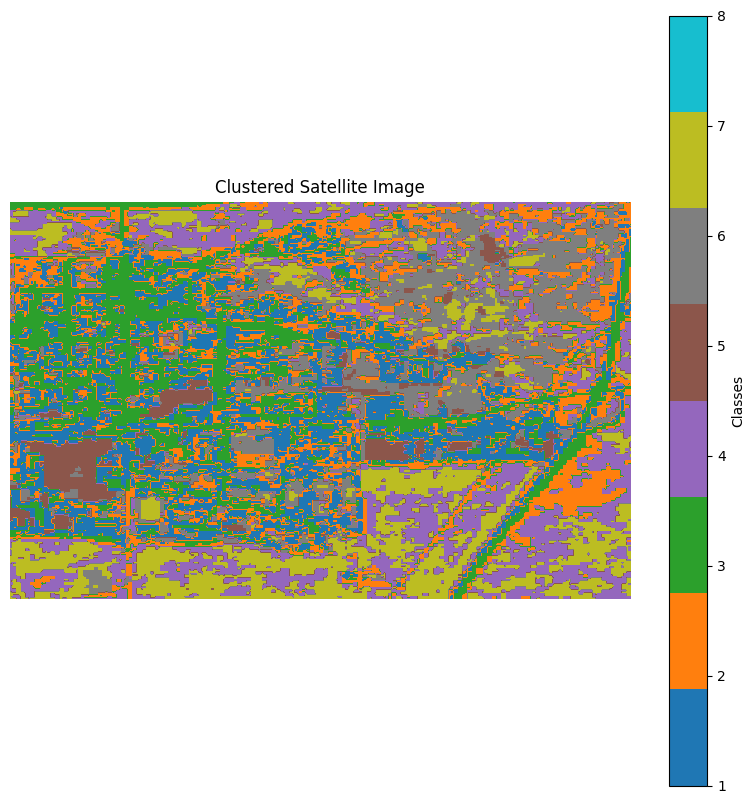

In [ ]:
### let's inspect our results visually

import numpy as np
import matplotlib.pyplot as plt

# Create a placeholder array for the visualization
clustered_image = np.zeros((height, width), dtype=np.uint8)

# Iterate over each pixel and determine the assigned class
for idx, memberships in enumerate(pixel_membership):
    max_membership = np.max(memberships)
    max_classes = np.where(memberships == max_membership)[0]  # Classes with equal highest membership

    # If more than one class has the same highest membership, assign to class 8
    if len(max_classes) > 1:
        assigned_class = 8  # Placeholder class
    else:
        assigned_class = max_classes[0] + 1  # Add 1 to make class indices start from 1

    # Convert flattened index back to 2D position
    row = idx // width
    col = idx % width
    clustered_image[row, col] = assigned_class

# Define a color map for the classes (8 classes)
cmap = plt.cm.get_cmap('tab10', 8)

# Plot the clustered image
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image, cmap=cmap, vmin=1, vmax=8)
plt.colorbar(ticks=range(1, 9), label="Classes")
plt.title("Clustered Satellite Image")
plt.axis('off')
plt.show()

So, far away from what was intended, but you saw the workflow. Supervised learning (even when using random forests or svp) may have been saver.

<>

<>

## (9) Segment green spaces using spectral indices

So, in a way this question is a bit like the one before: as long as we find a good clustering strategy we may be able to segment both vegetation and pavement in one go. So, let's try using c-means clustering again, but this time using spectral indices as before.

In [ ]:
# Band indices for Sentinel-2 data
B3 = stacked_data[:, :, 2]  # Green
B4 = stacked_data[:, :, 3]  # Red
B8 = stacked_data[:, :, 7]  # NIR
B11 = stacked_data[:, :, 10]  # SWIR1

# Avoid division by zero
epsilon = 1e-10

# Calculate spectral indices
ndbi = (B11 - B8) / (B11 + B8 + epsilon)  # NDBI
ndvi = (B8 - B4) / (B8 + B4 + epsilon)   # NDVI
mndwi = (B3 - B11) / (B3 + B11 + epsilon)  # MNDWI
rvi = B8 / (B4 + epsilon)  # RVI

# Stack indices into a new numpy array
indices_stack = np.stack([ndbi, ndvi, mndwi, rvi], axis=-1)  # Shape: (rows, cols, 4)

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import skfuzzy as fuzz

# Assume stacked_data is a 3D NumPy array with shape (height, width, bands)
# Flatten the 3D image into 2D for clustering (each row is a pixel, each column is a band)
height, width, bands = indices_stack.shape
reshaped_data = indices_stack.reshape(-1, bands).T  # Transpose for FCM input format

# Number of clusters
n_clusters = 7

# Perform fuzzy c-means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    reshaped_data, n_clusters, 2, error=0.005, maxiter=1000, init=None
)

# Membership probabilities for each class (n_clusters x n_pixels)
pixel_membership = u.T

# Determine the class for each pixel based on maximum membership probability
pixel_classes = np.argmax(pixel_membership, axis=1)

# Count the number of pixels in each class
class_counts = np.zeros(n_clusters)
for i in range(n_clusters):
    class_counts[i] = np.sum(pixel_membership[:, i])

# Convert counts to percentages
total_pixels = reshaped_data.shape[1]
class_percentages = (class_counts / total_pixels) * 100

# Store percentages in a dictionary
class_percentages_dict = {f"Class_{i+1}": class_percentages[i] for i in range(n_clusters)}

print("Class Percentages:", class_percentages_dict)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Class Percentages: {'Class_1': 15.138355366108385, 'Class_2': 13.940689734832937, 'Class_3': 15.131796873843797, 'Class_4': 17.390514621094173, 'Class_5': 12.719783735558973, 'Class_6': 18.83295647921807, 'Class_7': 6.845903189343651}


In [ ]:
# Now predict the total area of each class in that image based on the fuzzy percentages

# Sum of all class percentages
sum_of_sums = sum(class_percentages_dict.values())

# Calculate the percentage contribution of each class to the total sum of sums
percentage_contributions = {
    class_name: (value / sum_of_sums) * 100 for class_name, value in class_percentages_dict.items()
}

# Area of one pixel in square meters
pixel_area = 256 * 256  # 65,536 m²

# Total number of pixels
total_pixels = height * width

# Total area covered by all pixels
total_area = total_pixels * pixel_area  # in square meters

# Predicted area for each class
predicted_areas = {
    class_name: (percentage / 100) * total_area for class_name, percentage in percentage_contributions.items()
}

print("Percentage Contributions:", percentage_contributions)
print("Predicted Areas (m²):", predicted_areas)

Percentage Contributions: {'Class_1': 15.138355366108389, 'Class_2': 13.94068973483294, 'Class_3': 15.1317968738438, 'Class_4': 17.390514621094173, 'Class_5': 12.719783735558977, 'Class_6': 18.832956479218073, 'Class_7': 6.845903189343653}
Predicted Areas (m²): {'Class_1': 1028973962.9535544, 'Class_2': 947567051.7598999, 'Class_3': 1028528173.5918115, 'Class_4': 1182056195.320318, 'Class_5': 864580462.1281589, 'Class_6': 1280100869.2091823, 'Class_7': 465325061.03707486}


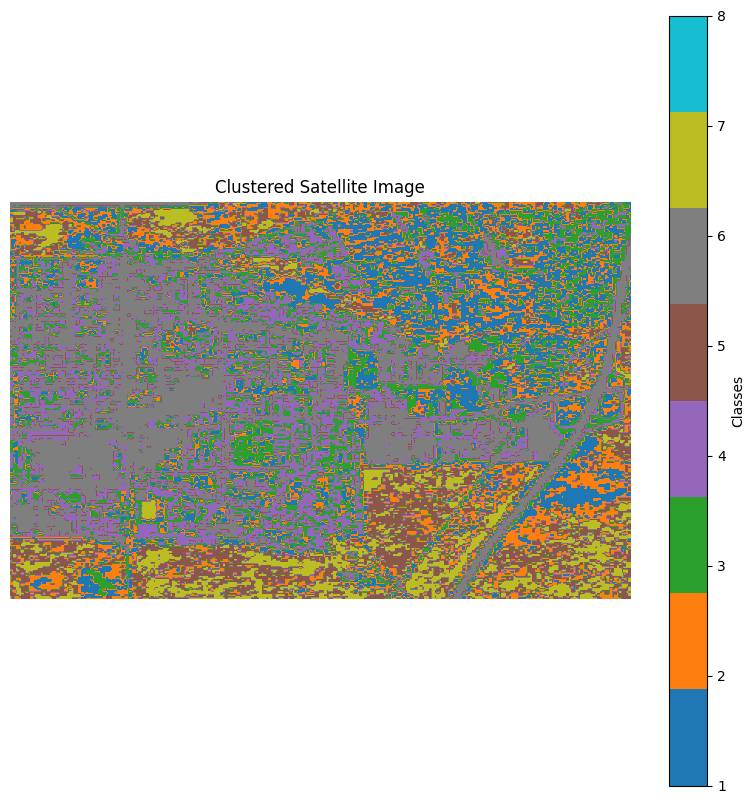

In [ ]:
### let's inspect our results visually

import numpy as np
import matplotlib.pyplot as plt

# Create a placeholder array for the visualization
clustered_image = np.zeros((height, width), dtype=np.uint8)

# Iterate over each pixel and determine the assigned class
for idx, memberships in enumerate(pixel_membership):
    max_membership = np.max(memberships)
    max_classes = np.where(memberships == max_membership)[0]  # Classes with equal highest membership

    # If more than one class has the same highest membership, assign to class 8
    if len(max_classes) > 1:
        assigned_class = 8  # Placeholder class
    else:
        assigned_class = max_classes[0] + 1  # Add 1 to make class indices start from 1

    # Convert flattened index back to 2D position
    row = idx // width
    col = idx % width
    clustered_image[row, col] = assigned_class

# Define a color map for the classes (8 classes)
cmap = plt.cm.get_cmap('tab10', 8)

# Plot the clustered image
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image, cmap=cmap, vmin=1, vmax=8)
plt.colorbar(ticks=range(1, 9), label="Classes")
plt.title("Clustered Satellite Image")
plt.axis('off')
plt.show()

Let's compare that with the original image:

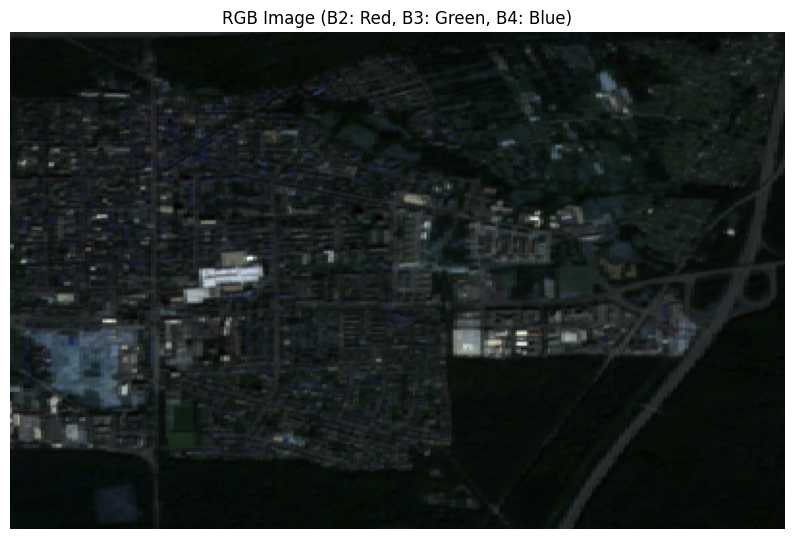

In [ ]:
import matplotlib.pyplot as plt

# Extract B2, B3, and B4 channels
r_channel = stacked_data[:, :, 1]  # B2
g_channel = stacked_data[:, :, 2]  # B3
b_channel = stacked_data[:, :, 3]  # B4

# Normalize the channels for display
def normalize_channel(channel):
    """Normalize channel values to the range [0, 1] for visualization."""
    return (channel - channel.min()) / (channel.max() - channel.min())

r_normalized = normalize_channel(r_channel)
g_normalized = normalize_channel(g_channel)
b_normalized = normalize_channel(b_channel)

# Stack the normalized channels to form an RGB image
rgb_image = np.stack((r_normalized, g_normalized, b_normalized), axis=-1)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("RGB Image (B2: Red, B3: Green, B4: Blue)")
plt.axis('off')
plt.show()

Closer but still far off - here fuzzy c-means clustering predicts an area for class 6 of 1280100869.2091823 - while Open Street Map suggests an area of 53187.46 square meters. So yeah... Point is: segmentation is not super simple - if it can be done by clustering a lot of fine-tuning, but supervised methods are state of the art.

Both in the case of streets as well as vegetation you can see from the selected image that there are strucutres present in the image that are below or hit the resolution limit of the image - thus, I propose that "fuzzy" pixel-level classification is preferable over segmentation only; there will be many mixed pixels in urban areas.

Vegetation mapping should utilize the fluorescent properties of chlorophyll content of plants, which is visible in the near infrared channel:

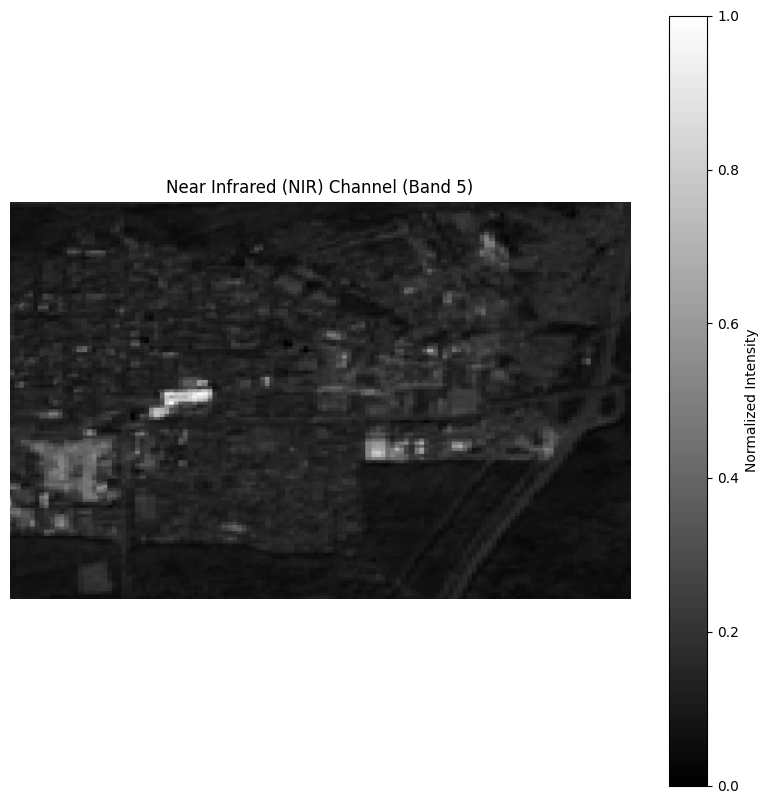

In [ ]:
# Extract the NIR channel (band 5)
nir_channel = stacked_data[:, :, 4]  # Band 5 (0-based index)

# Normalize the NIR channel for display
nir_normalized = (nir_channel - nir_channel.min()) / (nir_channel.max() - nir_channel.min())

# Plot the NIR channel as a grayscale image
plt.figure(figsize=(10, 10))
plt.imshow(nir_normalized, cmap='gray')
plt.title("Near Infrared (NIR) Channel (Band 5)")
plt.axis('off')
plt.colorbar(label="Normalized Intensity")
plt.show()

Now, it seems obvious though that chlorophyl content should not relate linearly to presence of vegetation: vegetation types may vary in the amount of chlorophyl content and vegetation may be present in different areas. Thus, the question arises whether it is easier to estimate the "green" volume rather than than the vegetation area. However, the ground truth may only include vegetation area. A point we should discuss to make the most informed decision possible.

<>

<>

## (10) determine ground temperature (hint: you may need to combine images from different satellite missions)

a tutorial can be found here: https://medium.com/@javijit96/estimation-of-land-surface-temperature-using-landsat-8-data-in-google-earth-engine-d691fa759d55

In python:

In [ ]:
import ee
import geemap
import geopandas as gpd

# Load GeoJSON file containing Frankfurt's boundary
geojson_url = 'https://raw.githubusercontent.com/GeoSchnitz/Frankfurt_Main-Offene_Geodaten/master/Stadtteil_Grenzen/ffm_city_districts_cartoDB.geojson'
gdf = gpd.read_file(geojson_url)

# Calculate the bounding box of Frankfurt
bounding_box = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

# Convert bounding box to an Earth Engine geometry
bounding_box_geom = ee.Geometry.Rectangle([bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3]])

# Define the date range
start_date = '2014-01-01'
end_date = '2014-12-30'

# Function to apply scale factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Cloud mask function
def cloud_mask(image):
    cloud_shadow_bitmask = (1 << 3)
    cloud_bitmask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(qa.bitwiseAnd(cloud_bitmask).eq(0))
    return image.updateMask(mask)

# Load and process the image collection
image = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(bounding_box_geom) \
            .filterDate(start_date, end_date) \
            .map(apply_scale_factors) \
            .map(cloud_mask) \
            .median() \
            .clip(bounding_box_geom)

# Define NDVI
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Calculate NDVI min and max
ndvi_min = ee.Number(ndvi.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=bounding_box_geom,
    scale=30,
    maxPixels=1e9
).get('NDVI'))

ndvi_max = ee.Number(ndvi.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=bounding_box_geom,
    scale=30,
    maxPixels=1e9
).get('NDVI'))

# Fraction of vegetation (FV)
fv = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')

# Emissivity (EM)
em = fv.multiply(0.004).add(0.986).rename('EM')

# Land Surface Temperature (LST)
thermal = image.select('ST_B10').rename('thermal')
lst = thermal.expression(
    '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15',
    {'TB': thermal, 'em': em}
).rename('LST')

# Visualization parameters
ndvi_params = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
lst_params = {
    'min': 18.47, 'max': 42.86,
    'palette': [
        '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
        '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
        '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
        'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
        'ff0000', 'de0101', 'c21301', 'a71001', '911003'
    ]
}

# Create a map
map_ = geemap.Map(center=[50.1109, 8.6821], zoom=12)

# Add layers to the map
map_.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.15}, 'True Color (432)')
map_.addLayer(ndvi, ndvi_params, 'NDVI')
map_.addLayer(lst, lst_params, 'Land Surface Temperature')

# Add legends and title
#map_.add_legend(title='Land Surface Temperature (°C)', labels=['Low', 'High'], colors=['blue', 'red'])
#map_.add_legend(title='NDVI', labels=['Low', 'High'], colors=['blue', 'green'])
#map_.add_title('Land Surface Temperature - 2023 - Frankfurt')

# Display the map
#map_.to_html('LST_Map.html')
map_

Map(center=[50.1109, 8.6821], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

<>

<>

## (11) Try to determine the topography of Frankfurt from shadows

This is a mock question: trying to determine the topography of a city from satellite imagery is an ongoing area of research and not an established method. See literature about it for example here:
https://openaccess.thecvf.com/content/CVPR2021W/EarthVision/papers/Derksen_Shadow_Neural_Radiance_Fields_for_Multi-View_Satellite_Photogrammetry_CVPRW_2021_paper.pdf?utm_source=chatgpt.com


Last but not least, it has been tried to use off-nadir images to enhance urban green volume estimates: https://www.tandfonline.com/doi/pdf/10.1080/22797254.2018.1431057?utm_source=chatgpt.com
